In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.signal as signal
import bitarray
from fixedpoint import FixedPoint
import random

NOTE: If you're going to change any constants, make sure to read the NOTE section.

# BLE Simulation

The main goal of this simulation is to derive new filter coefficients and estimate BER. For simplicity, the BLE packet assembly and disassembly is NOT correct. The shortcomings and inaccuracies are documented. Most of the analog level code is copied from <code>rfsim.ipynb</code> and <code>lrwpan.ipynb</code>.

For RTL implementation everything up to the FSK demodulator should be shared and, with reconfigurable filter coefficients, BLE should be a superset of 802.15.4. As such, one should ensure that all of the constants match up between the two simulations.

The CDR design from 802.15.4 should be reusable albeit with 32 cycles per bit instead of 16. Interestingly enough, the same phase shift of 1 cycle, which would now mean up to 16 cycles to sync, works well. Since the new CDR returns the integrator of greatest confidence, it should be accurate even while syncing to a signal.

One potential issue with the CDR is that packet length isn't known until after dewhitening by the baseband. We ended up completely refactoring the baseband to send an end-of-packet signal and also be byte-oriented.

In [2]:
F_CR  = 100e6 # lower freq for easier computation, same math
F_DF  = 500e3 # 500kHz deviation max
F_IF  = 2e6   # 2MHz
F_ADC = 32e6  # 32Msamples/s
F_DAC = 32e6  # 32Msamples/s

F_BR  = 1e6   # 1Mbps
F_DEV = 250e3 # 250kHz

FS_CR = 16 * F_CR # oversample for that smoothness

## TX Chain

BLE uses a frequency deviation of 250kHz and transmits bits at 1Mbps. Bits are transmitted out LSB first.

Analog RF provides a set of bits that tune the oscillators controlling what frequency is currently being transmitted. Due to high nonlinearity of the VCO, these bits must be tuned for each frequency (includes channel!) which means reloading the LUTs with every channel change.

In [3]:
# NOTE: experimentally found for 16*100MHz RF sample rate and BLE
SNR0 = 28 # SNR of signal with unscaled np.random.normal

In [4]:
def rf_mod(data, fs, SNR=25.0):
    """
    Performs CPFSK on a sequence of desired deviations. +1 is F_DF above and -1 is F_DF below.
    
    Parameters:
    data: Numpy array of floats
    fs: sample rate in Hz of data array
    SNR: desired SNR in dB
    
    Returns:
    ts: timestamp in seconds for each in sample
    ys: value of signal
    """
    # duplicate points (like a zero-order hold DAC)
    n_samples = int(len(data)*FS_CR/fs)
    data = np.kron(data, np.ones(n_samples//len(data)))
    
    # frequency modulate
    dt = 1/FS_CR
    ts = np.r_[0:n_samples]*dt
    theta = 2*np.pi*F_CR*ts + 2*np.pi*F_DF*(dt*np.cumsum(data))
    ys = np.sin(theta)
    
    # add noise
    P = SNR0 - SNR # gain for noise in dB
    n = 10**(P/20) * np.random.normal(size=ys.shape)
    ys = ys + n
    
    return ts, ys

References:
- https://www.mathworks.com/help/signal/ref/gaussdesign.html
- https://www.oscium.com/sites/default/files/WhitePaper_Simple_Signal_Shaper_GFSK.pdf

A BLE packet consists of a 1-byte preamble, 4-byte Access Address, 2 to 257-byte PDU, and 3-byte CRC (computed over the PDU).

The 2nd byte of the PDU contains the length of the data that follows, not including the CRC. The PDU and CRC are also whitened to remove long strings of 1s and 0s. For simplicity, we DO NOT do these things and instead just append a packet length after the AA followed by the data.

Gaussian filtering is implemented. For hardware implementation, this can either be an FIR filter (easy but expensive) or a ROM LUT. At BT=0.5, only the adjacent bits have non-negligible affect on the current bit's waveform. As such, we can store calibrated waveforms in a 3-bit LUT (2-bit if we consider symmetry). We ended up doing a downsampled FIR filter.

In [5]:
def ble_mod(data, AA=b'\xd6\xbe\x89\x8e', SNR=25.0, BT=0.5, fs=F_DAC):
    """
    Modulates a BLE packet given the data
    
    Parameters:
    data: byte-string
    AA: access address
    SNR: noise to pass to rf_mod
    BT: BT of Gaussian filter
    fs: sample rate of DAC
    
    Returns:
    ts: timestamps for each sample
    sig: samples of the modulated RF signal
    """
    # prepend preamble, AA, and very incorrect "PDU"
    data = (b'\x55' if AA[0] & 0x01 else b'\xAA') + AA + len(data).to_bytes(1, 'little') + data
    
    # constants
    samples_per_bit = int(fs/F_BR)
    sdev = F_DEV / F_DF # signal level for 250kHz frequency deviation
    
    # convert to bitstream, NRZ array, upsample
    bs = bitarray.bitarray(endian='little')
    bs.frombytes(data)
    bs = np.array([sdev if b else -sdev for b in bs])
    bs = np.kron(bs, np.ones(samples_per_bit))
    
    # Gaussian filter
    if BT and samples_per_bit > 1:
        sigma = np.sqrt(np.log(2))/(2*np.pi*BT) * samples_per_bit # scale to sample rate!
        bs = ndimage.gaussian_filter1d(bs, sigma, mode='nearest')
    
    # modulate bitstream
    ts, sig = rf_mod(bs, fs, SNR=SNR)
    return ts, sig

### Gaussian Filter

The following is meant to determine the impact of Gaussian filtering and an appropriate sample rate to balance cost and benefit.

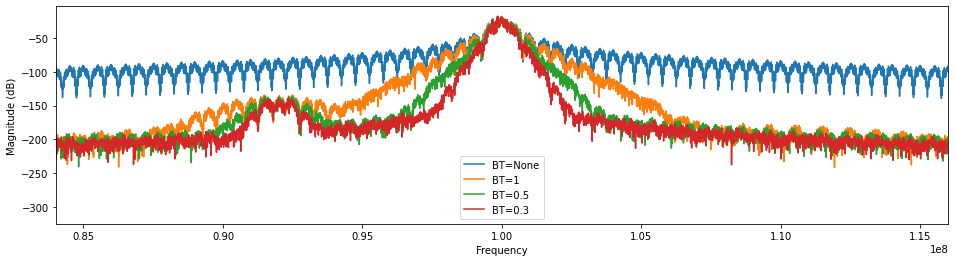

In [6]:
SNR = 300.0 # remove added noise
data = b'BLE needs GFSK <3'
bts = [None, 1, 0.5, 0.3]

plt.figure(figsize=(16,4))
for bt in bts:
    ts, sig = ble_mod(data, SNR=SNR, BT=bt)
    plt.magnitude_spectrum(sig, Fs=FS_CR, scale='dB')
plt.xlim([F_CR-16e6,F_CR+16e6])
plt.legend([f"BT={bt}" for bt in bts])
plt.show()

Based on above, we need Gaussian filtering. Next is to determine an appropriate sample rate that still provides enough benefit.

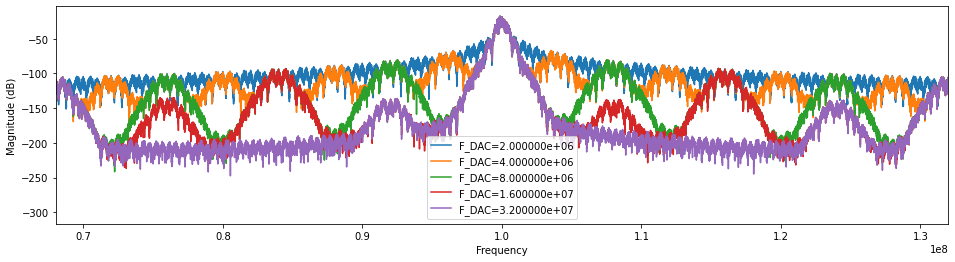

In [7]:
SNR = 300.0 # remove added noise
BT = 0.5
data = b'BLE needs GFSK <3'
dacs = [2, 4, 8, 16, 32]

plt.figure(figsize=(16,4))
for d in dacs:
    ts, sig = ble_mod(data, SNR=SNR, BT=BT, fs=d*F_BR)
    plt.magnitude_spectrum(sig, Fs=FS_CR, scale='dB')
plt.xlim([F_CR-32e6,F_CR+32e6])
plt.legend([f"F_DAC={d*F_BR:3e}" for d in dacs])
plt.show()

Based on above, BT controls the rate of dropoff while F_DAC controls the frequency of peaks within that dropoff. We can derive filter coefficients as follows. Note this kind of filter has a constant group delay. We ended up using a 16MHz DAC frequency.

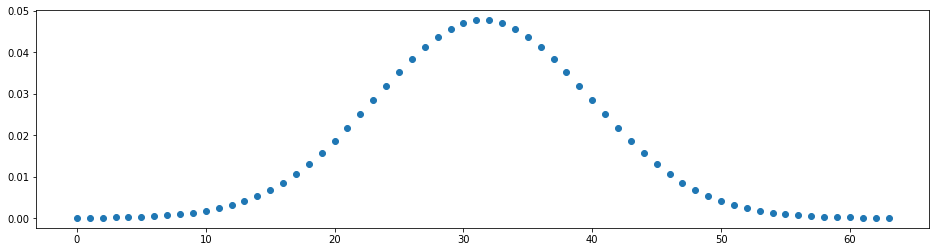

In [8]:
# same interface as MATLAB's gaussdesign except can manually set number of taps if want to
def gaussdesign(bt=0.5, span=2, sps=int(F_DAC/F_BR), ntaps=None):
    sigma = np.sqrt(np.log(2))/(2*np.pi*bt)
    ntaps = ntaps if ntaps else span * sps + 1 # why MATLAB adds 1 idk...
    t = np.linspace(-1,1,num=ntaps)
    h = 1/np.sqrt(2*np.pi)/sigma * np.exp(-t**2/2/sigma**2)
    return h / np.sum(h) # normalize to unity gain at DC
    
fir = gaussdesign(bt=0.5,ntaps=64) # lower F_DAC to shorten filter
plt.figure(figsize=(16,4))
plt.scatter(range(len(fir)), fir)
plt.show()

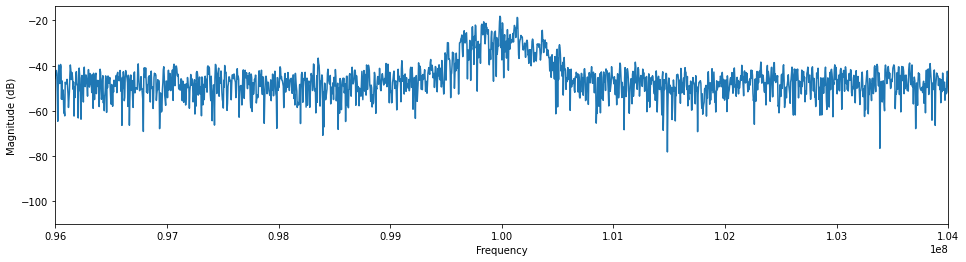

In [9]:
ts, sig = ble_mod(b'hello world! Meet BLE :P', SNR=20.0)

# channels are 2MHz apart
plt.figure(figsize=(16,4))
plt.magnitude_spectrum(sig, Fs=FS_CR, scale='dB')
plt.xlim([F_CR-4e6,F_CR+4e6])
plt.show()

## RX Chain

Like 802.15.4's SHR, BLE searches for the 4-byte Access Address (1/(2^32) chance of random match) to find the start of a valid packet. Note that the Access Address is not whitened, but everything after it is. Since we depend on the Access Address to find byte boundaries, there are several rules to ensure maximum accuracy of matches.

For simplicity, this RX chain is only accurate up to the start of packet capture since it doesn't do de-whitening or a CRC check.

In [9]:
ADC_BITS = 8
ADC_M = 1
ADC_N = 7

IMG_BITS = 16
IMG_M = 4
IMG_N = 12

DEMOD_BITS = 16
DEMOD_M = 4
DEMOD_N = 12

In [10]:
def rf_demod(sig, ps=0):
    """
    Demodulates I/Q signals from F_CR to F_IF and ADC samples. This step is done in analog RF.
    
    Parameters:
    sig: raw RF signal sampled as FS_CR
    ps: phase offset for LO
    
    Returns:
    ts: timestamps for each sample meant for plotting
    I: raw I samples from ADC
    Q: raw Q samples from ADC
    """
    # generate the LO mixing signals
    F_LO = F_CR - F_IF
    dt = 1/FS_CR
    ts = np.r_[0:len(sig)]*dt
    I_lo = np.sin(2*np.pi*F_LO*ts - ps)
    Q_lo = np.sin(2*np.pi*F_LO*ts - np.pi/2 - ps)
    
    # mix!
    I = sig*I_lo
    Q = sig*Q_lo
    
    # filter out (~twice) the carrier (well into cutoff freq of amplifiers)
    lpf_b, lpf_a = signal.butter(16, F_CR, fs=FS_CR)
    I = signal.filtfilt(lpf_b, lpf_a, I)
    Q = signal.filtfilt(lpf_b, lpf_a, Q)
    
    # downsample to ADC
    n_samples = int(len(sig)*F_ADC/FS_CR)
    ts = np.r_[0:n_samples]*1/F_ADC
    I  = signal.resample(I, n_samples)
    Q  = signal.resample(Q, n_samples)
    
    # BPF I/Q by 2*F_DF on either side of F_IF (~40dB/decade)
    bpf_b, bpf_a = signal.butter(1, [F_IF-2*F_DF, F_IF+2*F_DF], btype="bandpass", fs=F_ADC)
    I = signal.filtfilt(bpf_b, bpf_a, I)
    Q = signal.filtfilt(bpf_b, bpf_a, Q)
    
    # AGC to just below saturation
    m = max(np.max(I), np.max(Q), -np.min(I), -np.min(Q))
    I = I / m * 0.98
    Q = Q / m * 0.98
    
    # discretize points (handoff to digital RF)
    I = [FixedPoint(i,signed=1,m=ADC_M,n=ADC_N) for i in I]
    Q = [FixedPoint(q,signed=1,m=ADC_M,n=ADC_N) for q in Q]
    
    return ts, I, Q

In [11]:
def apply_fir(b, x):
    """
    Implements y[n] = b[0]*x[n] + b[1]*x[n-1] + ...
    
    Parameters:
    b: filter coefficients
    x: signal to filter as an array of FixedPoint
    
    Returns:
    y: filtered signal
    """
    xm, xn = x[0].m, x[0].n # FixedPoint likes to grow...
    px = x + [0]*(len(b)-1) # pad with zeros
    y = [0]*len(x)
    for n in range(len(x)):
        y[n] = 0
        for i in range(len(b)):
            y[n] += b[i] * px[n-i]
        y[n].resize(xm, xn) # should technically resize after each calc, but slower
    
    return y

Slightly modified from <code>lrwpan.ipynb</code> to implement the I delay as an FIR filter instead. We had lots of extra area so did the FIR filter.

In [12]:
def image_reject(I, Q):
    """
    Uses the Q signal to image reject the I signal
    
    Parameters:
    I: I signal
    Q: Q signal
    
    Returns:
    sig: image rejected signal
    """
    # design filters
    N = 29 # length of filter
    
    ns = np.r_[-(N-1)//2:(N-1)//2+1]
    hilbert_b = [(0 if n%2==0 else 2/np.pi/n) for n in ns] # TODO window?
    hilbert_b = [FixedPoint(c,signed=1,m=IMG_M,n=IMG_N) for c in hilbert_b]
    
    delay_b = [0]*N
    delay_b[(N-1)//2] = 1
    delay_b = [FixedPoint(c,signed=1,m=IMG_M,n=IMG_N) for c in delay_b]
    
    # scale to same fixed point size
    [i.resize(IMG_M, IMG_N) for i in I]
    [q.resize(IMG_M, IMG_N) for q in Q]
    
    # apply filters
    Qh = apply_fir(hilbert_b, Q)
    Id = apply_fir(delay_b, I)    
    sig = [i+q for i,q in zip(Id, Qh)]

    return sig

At 32MHz ADC, we have 32 samples per bit period (16 for 802.15.4) which determines the length of our filter. With this length, we can actually implement similar length filters as last year's method so with software configurable coefficients we can use that as a backup.

NOTE: See <code>lrwpan.ipynb</code> for information on updating the filters for different ADC sample rate.

In [13]:
def gfsk_demod(sig, ps=0):
    """
    Generates an oversampled FSK bitstream from an RF signal
    
    Parameters:
    sig: raw RF signal
    ps: phase offset for LO
    
    Returns:
    chips: oversampled bitstream
    """
    # design "filters"
    SPC = int(F_ADC/F_BR)
    dt = 1/F_ADC
    ts = np.r_[0:SPC]*dt
    
    # scaled so filter output <1
    s0_b = np.sin(2*np.pi*(F_IF-F_DEV)*ts) / 16
    c0_b = np.cos(2*np.pi*(F_IF-F_DEV)*ts) / 16
    s1_b = np.sin(2*np.pi*(F_IF+F_DEV)*ts) / 16
    c1_b = np.cos(2*np.pi*(F_IF+F_DEV)*ts) / 16
    lpf_b = signal.firwin(21, F_BR, pass_zero="lowpass", fs=F_ADC) # max freq is 500kHz square wave

    s0_b = [FixedPoint(k,signed=1,m=DEMOD_M,n=DEMOD_N) for k in s0_b]
    c0_b = [FixedPoint(k,signed=1,m=DEMOD_M,n=DEMOD_N) for k in c0_b]
    s1_b = [FixedPoint(k,signed=1,m=DEMOD_M,n=DEMOD_N) for k in s1_b]
    c1_b = [FixedPoint(k,signed=1,m=DEMOD_M,n=DEMOD_N) for k in c1_b]
    lpf_b = [FixedPoint(c,signed=1,m=DEMOD_M,n=DEMOD_N) for c in lpf_b]
    
    # grab I/Q signals from analog RF and image reject
    ts, I, Q = rf_demod(sig, ps=ps)
    sig = image_reject(I, Q)
    
    # apply each filter
    sig_s0 = apply_fir(s0_b, sig)
    sig_c0 = apply_fir(c0_b, sig)
    sig_s1 = apply_fir(s1_b, sig)
    sig_c1 = apply_fir(c1_b, sig)
    
    # get magnitude of each frequency
    sig0 = [(s**2 + c**2) for s, c in zip(sig_s0, sig_c0)]
    sig1 = [(s**2 + c**2) for s, c in zip(sig_s1, sig_c1)]
    [s.resize(DEMOD_M, DEMOD_N) for s in sig0]
    [s.resize(DEMOD_M, DEMOD_N) for s in sig1]
    
    # lowpass filter
    sig0 = apply_fir(lpf_b, sig0)
    sig1 = apply_fir(lpf_b, sig1)
    
    # subtract
    chips = [s1 - s0 for s0,s1 in zip(sig0, sig1)]
    [c.resize(DEMOD_M, DEMOD_N) for c in chips]
    
    # convert to bits
    chips = [c >= 0 for c in chips]
    
    return ts, chips

CDR is the same but with more samples per bit. In theory, due to returning the strongest integrator each time it should confidently return samples even with a near $\frac{\pi}{2}$ shift.

In [14]:
def integrator(bits):
    """ Returns sum based on majority 1s or 0s """
    bits = [2*b-1 for b in bits]
    return sum(bits)

def cdr(bits, fs=F_BR):
    """
    Takes oversampled bits at F_ADC and samples correctly at fs
    
    Parameters:
    bits: oversampled bits
    fs: output bitrate of the bits
    
    Returns:
    bs: sampled bits at fs
    """
    # careful of off by one errors!!!
    
    SHIFT = 1 # determines resolution of our shifts
    SPC = int(F_ADC / fs) # samples per chip
    WINDOW = SPC + 2*SHIFT
    
    bs = []
    cntr = SPC
    w = [False] * WINDOW # w[0] is most recent chip
    for b in bits:
        w = [b] + w[:-1]
        
        cntr -= 1
        if cntr == 0:
            early   = integrator(w[:-2*SHIFT])
            present = integrator(w[SHIFT:-SHIFT])
            late    = integrator(w[2*SHIFT:])
            
            # careful of ordering, always prioritize present
            if ((abs(present) >= abs(early) and abs(present) >= abs(late)) 
                or (abs(early) == abs(late))):
                bs.append(present >= 0)
                cntr = SPC
            elif abs(early) > abs(late):
                bs.append(early >= 0)
                cntr = SPC + SHIFT
            else: # abs(late) > abs(early)
                bs.append(late >= 0)
                cntr = SPC - SHIFT
    return bs

<code>find_packets</code> is completely WRONG! It's purpose is just to check out what SNR we start losing bits at.

In [15]:
def find_packets(chips, AA=b'\xd6\xbe\x89\x8e'):
    """
    (Incorrectly) finds packets in a chipstream, performs preamble detection as it goes
    
    Parameters:
    chips: raw chipstream
    AA: Access Address
    
    Returns:
    packets: the data field of found packets
    """
    # need to match entire Access Address
    # 1-byte preamable for AGC and CDR to sync
    AA = int.from_bytes(AA, 'little')
    
    packets = []
    
    state = "search"
    
    pkt_len = 0
    curr_pkt = b''
    seq_ct = 0
    seq_sr = 0
    for c in chips:
        # chips come in LSB first, so add to MSB end
        seq_sr = (seq_sr >> 1) | (c << (32 - 1))
        mrb = seq_sr >> 24 # "most recent byte"
        
        if state == "search":
            if seq_sr == AA:
                seq_ct = 0
                state = "length"
        elif state == "length": # incorrect, pull from baseband or dewhiten
            if seq_ct == 7:
                state = "data"
                pkt_len = mrb
                curr_pkt = b''
                
            seq_ct = (seq_ct + 1) % 8
        elif state == "data":
            if seq_ct == 7:
                curr_pkt += mrb.to_bytes(1,"little")
                pkt_len -= 1
                
            if pkt_len == 0: # careful! uses the next val of pkt_len
                packets.append(curr_pkt)
                state = "search"
                
            seq_ct = (seq_ct + 1) % 8
                
    return packets

In [16]:
def ble_demod(sig, ps=0):
    """
    (Incorrectly) search for BLE packets in RF modulated signal
    
    Parameters:
    sig: raw RF signal
    ps: phase offset for rf_demod
    
    Returns:
    packets: array of packet data fields
    """
    ts, chips = gfsk_demod(sig, ps=ps)
    cs = cdr(chips)
    return find_packets(cs)

# Testing

A couple of tests to demonstrate the whole chain (or really just the mod/demod). These take awhile. It's hard to find good numbers, but BLE appears to be designed for 10-15dB SNR. Since we're basically measuring SNR graphically, there's likely error in it.

In [17]:
def test(SNR=20.0, num_pkts=1, pkt_len=16, max_delay=20000):
    sigs = [np.zeros(5000)]
    for _ in range(num_pkts):
        data = random.randbytes(pkt_len)
        _, sig = ble_mod(data, SNR=SNR)
        sigs.append(sig)
        sigs.append(np.zeros(np.random.randint(max_delay)))
        print("Sending", data)
    sigs.append(np.zeros(5000))
    sig = np.hstack(sigs)
    
    plt.figure(figsize=(16,4))
    plt.magnitude_spectrum(sig, Fs=FS_CR, scale='dB')
    plt.xlim([F_CR-4e6,F_CR+4e6])
    plt.ylim([-50, -10])
    plt.show()
    
    print("Demodulating...")
    for p in ble_demod(sig, ps=0):
        print("Found!", p)

Sending b'\xff\xc8\xc7;\xaf\x04\xc1\x12'
Sending b'\x1e\xc0=%n\xcc,\xfd'


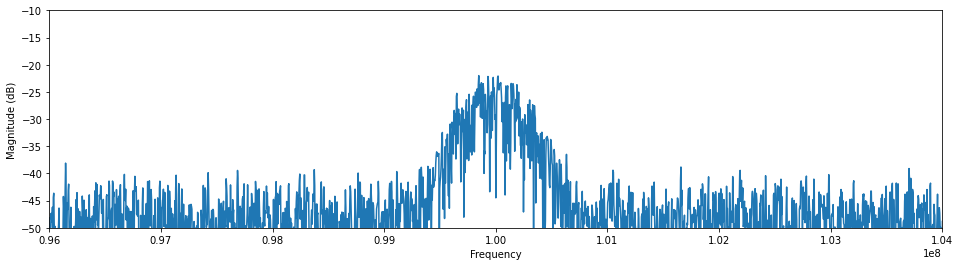

Demodulating...
Found! b'\xff\xc8\xc7;\xaf\x04\xc1\x12'
Found! b'\x1e\xc0=%n\xcc,\xfd'


In [18]:
test(SNR=20.0, num_pkts=2, pkt_len=8)

Sending b'\x86\xbc\x9a\t\xf7h\x1c;'
Sending b'\xc6\x16\xb3\xca}\xcf<\xb5'


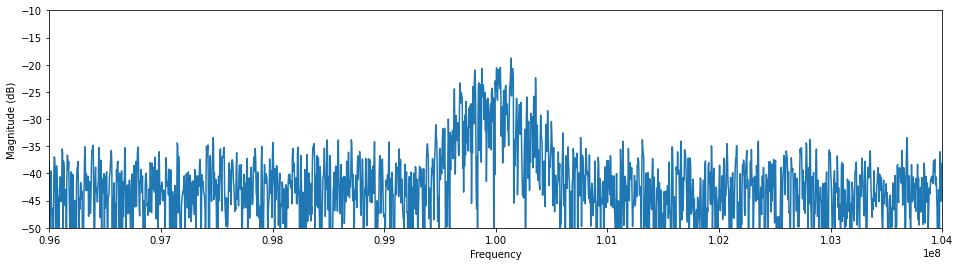

Demodulating...
Found! b'\x86\xbc\x9a\t\xf7h\x1c;'
Found! b'\xc6\x16\xb3\xca}\xcf<\xb5'


In [19]:
test(SNR=15.0, num_pkts=2, pkt_len=8)

Sending b'\xd4+.\xad\xaa\xdf\xd5\xdb'
Sending b'\x0c\xeb\xf7j\x04{\x06:'


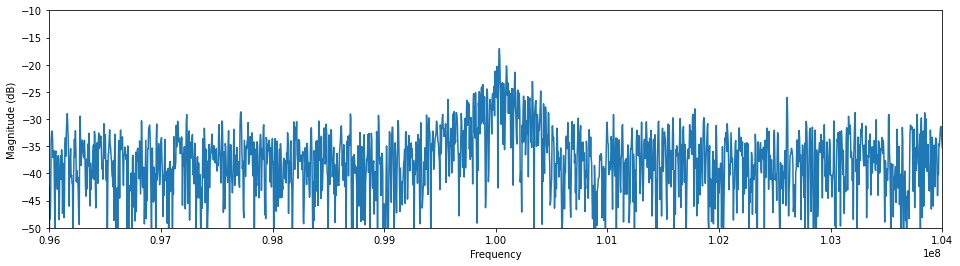

Demodulating...
Found! b''


In [20]:
test(SNR=10.0, num_pkts=2, pkt_len=8)